<a href="https://colab.research.google.com/github/seungmei/ESAA_23_2/blob/main/13%EC%A3%BC%EC%B0%A8%EA%B8%88%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#13주차금과제
## 파이썬 머신러닝 완벽가이드 ch7. 3~4 pg. 427~440
### Chapter 7. 군집화
#### 3. 평균이동

#### 3. 평균 이동
##### 평균 이동Mean Shift의 개요
- 확률 밀도 함수가 피크인 점을 군집 중심점으로 선정. 일반적으로 주어진 모델의 확률 밀도 함수를 찾기 위해 KDE를 이용.
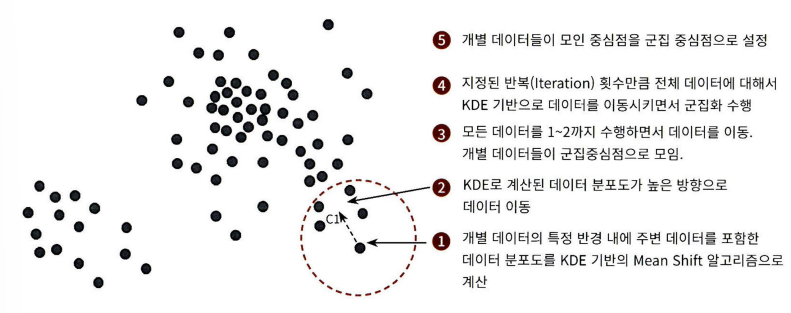

KDE는 Kernel 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적 방법.
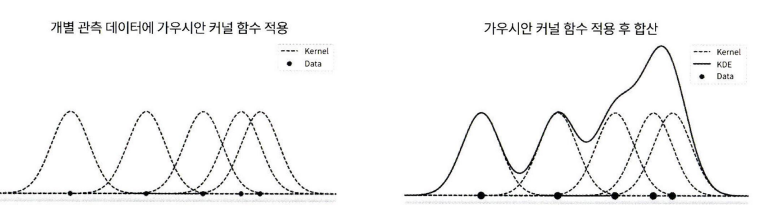

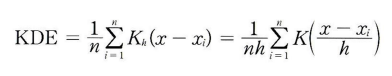

h를 어떻게 설정하느냐에 따라 확률 밀도 추정 성능을 크게 좌우. h가 작으면 좁고 뾰족한 KDE -> overfitiing. h가 크면 과도하게 평활화 KDE -> under-fitting
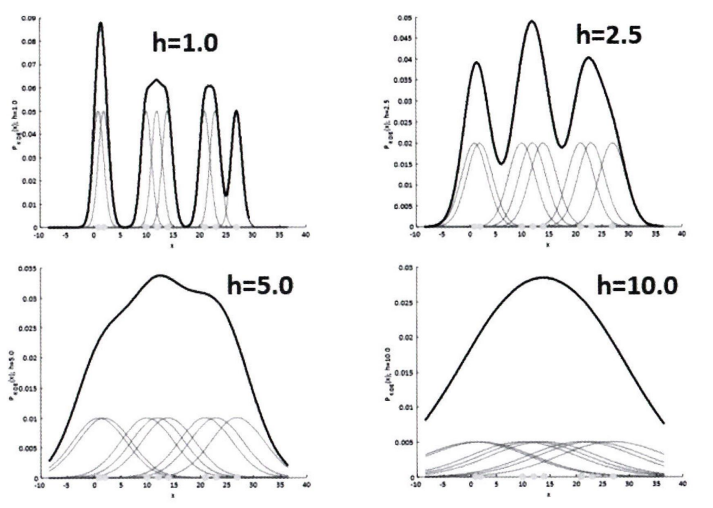

일반적으로 평균 이동 군집화는 대역폭이 클수록 평활화된 KDE로 인해 적은 수의 군집 중심점을 가지며 대역폭이 적을수록 많은 수의 군집 중심점을 가진다. 또한 평균 이동 군집화는 군집의 개수를 지정하지 않으며, 오직 대역폭의 크기에 따라 군집화를 수행한다.
- MeanShift 클래스

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))
#bandwidth값을 작게할수록 군집개수가 많아짐

cluster labels 유형: [0 1 2 3 4 5]


In [2]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


데이터의 분포 유형에 따라 bandwidth 값의 변화는 군집화 개수에 큰 영향을 미칠 수 있음. 따라서 MeanShift에서는 이 bandwidth를 최적화 값으로 설정하는 것이 매우 중요. 최적화된 bandwidth값을 찾기 위해서 estimate_bandwidth() 함수를 제공.

In [4]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:' ,round(bandwidth, 3))

bandwidth 값: 1.816


estimate_bandwidth()로 측정된 bandwidth를 평균 이동 입력값으로 적용해 동일한 make_blobs() 데이터 세트에 군집화 수행해보자

In [5]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

#estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift= MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))
#3개의 군집으로 구성된다.

cluster labels 유형: [0 1 2]


<function matplotlib.pyplot.show(close=None, block=None)>

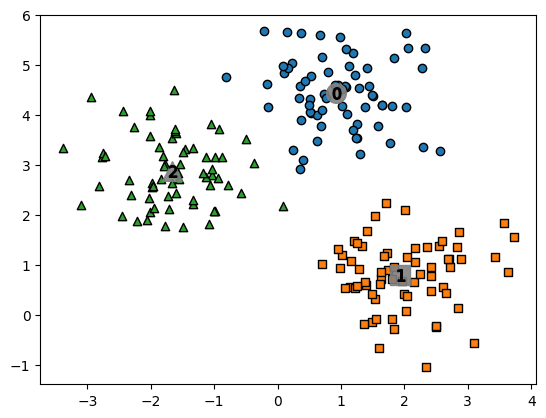

In [7]:
#구성된 3개의 군집을 시각화해보자
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]
  #군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y =label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  #군집별 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show

In [8]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: meanshift_label, dtype: int64


평균 이동의 장점: 데이터 세트의 형태를 특정 형태로 가정한다든가, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화가 가능. 또한 이상치의 영향력도 크지 않으며, 미리 군집의 개수를 정할 필요도 없음.
단점: 알고리즘 수행 시간이 오래 걸림. bandwidth의 크기에 따른 군집화 영향도가 매우 크다.
=> 컴퓨터 비전 영역에서 잘 쓰임. 미디어에서 특정 개체 구분하거나 움직임을 추적하는데 뛰어난 역할

#### 4. GMM(Gaussian Mixture Model)
가정: 군집화를 적용하고자 하는 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것.
목표: 섞인 데이터 분포에서 개별 유형의 가우시안 분포를 추출.

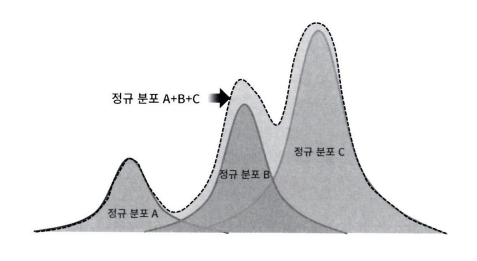

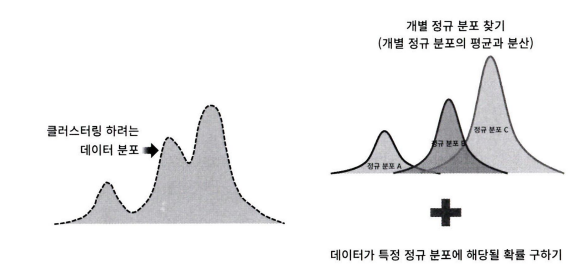

* 개별 정규 분포의 평균과 분산
* 각 데이터가 어떤 정규 분포에 해당되는지의 확률
GMM은 EM(Expectation and Maximization) 방법 적용.

##### GMM을 이용한 붓꽃 데이터 세트 군집화
GMM은 확률 기반 군집화. K-평균은 거리 기반 군집화.

In [9]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

- 파라미터
  - n_components: gaussian misture의 모델의 총 개수

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

#군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

#target값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


In [12]:
#붓꽃 데이터의 K-평균 군집화 수행 결과와 비교
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##### GMM과 K-평균의 비교
KMeans는 원형의 범위에서 군집화를 수행. 데이터 세트가 원형의 범위를 가질수록 KMeans의 군집화 효율은 더욱 높아짐.

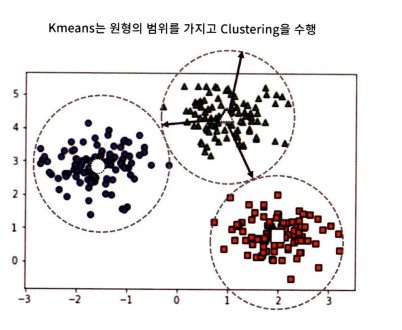

but, KMeans는 데이터가 길쭉한 타원형으로 늘어선 경우에는 군집화를 잘 수행하지 못함.

In [16]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦
X,y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

#길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341],[-0.40887718,0.85253229]]
X_aniso = np.dot(X,transformation)

#feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=["ftr1","ftr2"])
clusterDF["target"] = y

#생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, "target", iscenter=False)

NameError: ignored

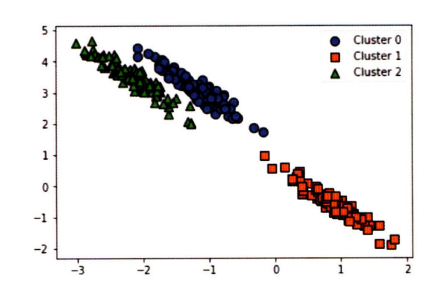

In [17]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF["kmeans_label"]=kmeans_label

visualize_cluster_plot(kmeans,clusterDF, "kmeans_label",iscenter=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: ignored

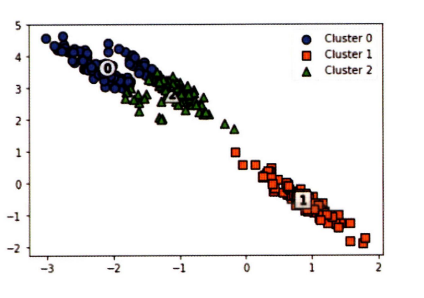

In [18]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용

gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF["gmm_label"] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정

visualize_cluster_plot(gmm, clusterDF, "gmm_label", iscenter=False)

NameError: ignored

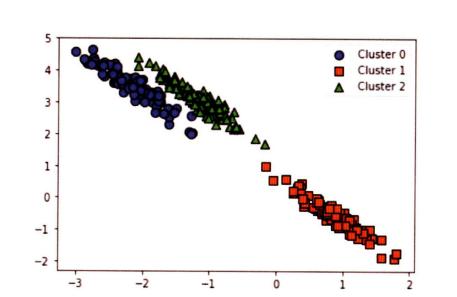

In [19]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n ### Gaussian Mixture Cluster ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

 ### Gaussian Mixture Cluster ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
